In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.stats.power import TTestIndPower
from tqdm import tqdm

## Количественные метрики

Количественная метрика - это числовая мера, которая используется для измерения и количественной оценки различных аспектов продукта или пользовательского опыта.

Примеры количественных метрик включают величина среднего чека, время прохождения уровня, средняя продолжительность сессии, количество опыта и так далее.

Посмотрим на t-test и U-критерий Манна-Уитни, посчитаем размер выборки, посмотрим на показатель $\alpha$ при АА-тесте и $1-\beta$ при АБ-тесте. 

### t-test Стьюдента

Ограничения:
- нормальное распределение выборочных средних
- однородность дисперсии
- отсутствие выбросов

### Проверим первое ограничение t-теста, а именно "нормальное распределение выборочных средних"

In [176]:
# напишем функцию, которая будет генерировать 
# данные из распределения Пуассона

def generate_data(mu1, mde, sample_size, func, range_size=1000):
    """
    Генерирует данные из Пуассоновского распределения и применяет указанную функцию к полученным выборкам.

    Параметры:
    - mu1 (float): Среднее значение первой группы.
    - mde (float): Разница между средними значениями первой и второй группы.
    - sample_size (int): Размер выборки для каждой группы.
    - func (function): Функция, принимающая две выборки и возвращающая результат их обработки.
    - range_size (int, по умолчанию 1000): Количество итераций генерации данных.

    Возвращает:
    - result (list): Список результатов применения функции к сгенерированным выборкам.

    """
    result = []
    for _ in tqdm(range(range_size)):
        a = np.random.poisson(lam=mu1, size=sample_size)
        b = np.random.poisson(lam=mu1+mde, size=sample_size)
        
        result.append(func(a, b))
    
    return result

mu1 = 2
mde = 0.3

def avg_tuple(x, y):
    return (np.mean(x), np.mean(y))

avg_array = generate_data(mu1=mu1, 
                            mde=mu1+mde,
                            sample_size=1000,
                            func=avg_tuple)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 3908.88it/s]


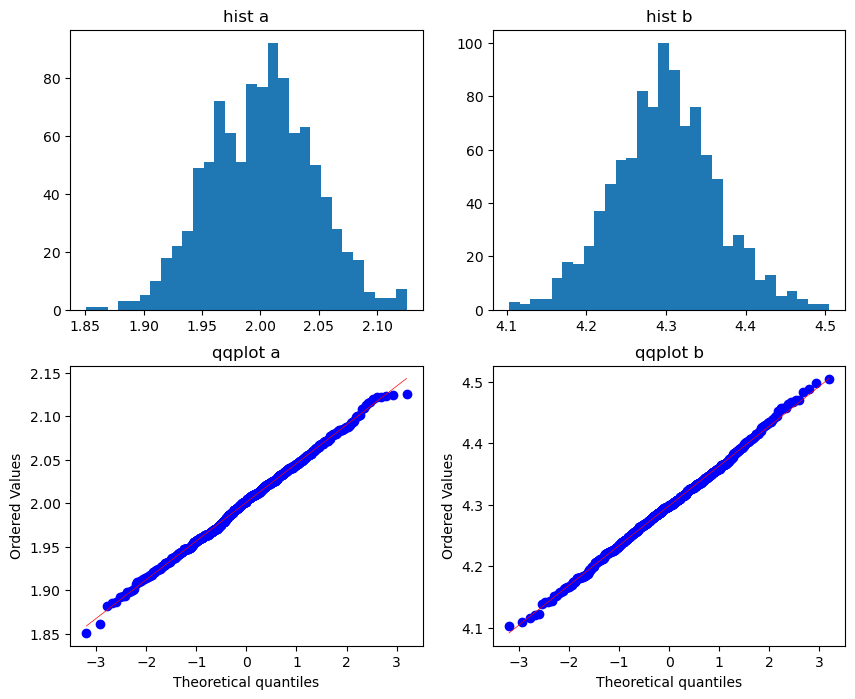

Выборка 1: p_value = 0.334, H0 не отвергаем
Выборка 2: p_value = 0.405, H0 не отвергаем


In [79]:
# построим гистограмму данных и граффик qqplot,
# который показывает связь теоретических квантилей
# нормального распределения и квантилей нашей выборки

def avg_hist(a_avg_array, b_avg_array):
    """
    Создает гистограммы и QQ-графики для массивов средних значений двух выборок.

    Параметры:
    - a_avg_array (array-like): Массив средних значений первой выборки.
    - b_avg_array (array-like): Массив средних значений второй выборки.

    Визуализирует гистограммы и QQ-графики для сравнения распределений средних значений двух выборок.

    """
    fig, axs = plt.subplots(2, 2, figsize=(10,8))

    bins = 30
    axs[0, 0].hist(a_avg_array, bins=bins)
    axs[0, 1].hist(b_avg_array, bins=bins)

    stats.probplot(a_avg_array, dist='norm', plot=axs[1,0])
    stats.probplot(b_avg_array, dist='norm', plot=axs[1,1])

    axs[0, 0].set_title('hist a')
    axs[0, 1].set_title('hist b')

    axs[1, 0].set_title('qqplot a')
    axs[1, 1].set_title('qqplot b')

    plt.show();


# и проверим гипотезу о нормальности распределения для каждой выборки

# Сформируем нулевую и альтернативную гипотезу:
# H0: выборка из нормального распределения
# H1: выборка не из нормального распределения

def test_of_normality(a_avg_array, b_avg_array):
    alpha = 0.05
    _, pval1 = stats.shapiro(a_avg_array)
    _, pval2 = stats.shapiro(b_avg_array)

    print(f'Выборка 1: p_value = {pval1:0.3f}, H0 {"не отвергаем" if pval1 > alpha else "отвергаем"}\n'
         f'Выборка 2: p_value = {pval2:0.3f}, H0 {"не отвергаем" if pval2 > alpha else "отвергаем"}')

    
avg_array = np.array(avg_array)

avg_hist(avg_array[:, 0], avg_array[:, 1])

test_of_normality(avg_array[:, 0], avg_array[:, 1])

Гистограммы показывают колокообразные, симметричные распределения с небольшими выбросами в хвостах. Графики qqplot показывают, что эмпирические квантили практически идеально соответствуют теоретическим значениям, за исключением некоторых выбросов в хвостах распределений. Критерий согласия Шапиро-Уилка, используемый для проверки нормальности распределения, показывает значениe p-value, которое больше заданного уровня значимости $\alpha$ для обеих выборок. Это означает, что у нас нет достаточных оснований для отвержения нулевой гипотезы.

### Второе требование гласит о необходимости равенства дисперсий двух выборок. Если дисперсии различаются, следует использовать тест Уэлча вместо теста Стьюдента. Формула для расчета степеней свободы t-распределения отличается между этими двумя тестами. При достаточно больших выборках, статистика t как для теста Стьюдента, так и для теста Уэлча стремится к нормальному распределению.

Давайте рассмотрим, как p-value ведет себя при разных дисперсиях и объемах выборок, когда мы используем тест Стьюдента, тест Уэлча и тест Стьюдента, где для расчета p-value мы будем использовать квантили нормального распределения.

In [6]:
def t_test(a_sample, b_sample):
    a_m = np.mean(a_sample)
    b_m = np.mean(b_sample)
    a_var = np.var(a_sample)
    b_var = np.var(b_sample)
    a_size= a_sample.size
    b_size = b_sample.size
    
    t_stat = (a_m - b_m) / (a_var/a_size + b_var/b_size)**(1/2) # считаем t статистику
    p_value = (1 - stats.norm().cdf(abs(t_stat))) * 2 # считаем p-value:
                                                      # (1 - модуль t стат.) считаем плотность веростности от
                                                      # t стат. до бесконечности
                                                      # умножаем на 2 при проверки двухсторонней гипотезы
    
    return t_stat, p_value

In [7]:
# сгенерируем выборки из распределения Пуассона с 
# различными значениями параметра lambda, 
# который одновременно является математическим 
# ожиданием и дисперсией этого распределения

mu1 = 2
mde = 0.5

p_vals_st = []
p_vals_welch = []
p_vals_norm = []
for i in tqdm(range(10, 1000, 10)):
    a = np.random.poisson(lam=mu1, size=i)
    b = np.random.poisson(lam=mu1+mde, size=i)
    
    _, pval_st = stats.ttest_ind(a, b, equal_var=True)     # t-test для одинаковой дисперсии
    _, pval_welch = stats.ttest_ind(a, b, equal_var=False) # t-test для разной дисперсии
    _, pval_norm = t_test(a, b)                            # t-test для одинаковой дисперсии, 
                                                           # p_value посчитано на нормальном распределении
    
    p_vals_st.append(pval_st)
    p_vals_welch.append(pval_welch)
    p_vals_norm.append(pval_norm)

df = pd.DataFrame({
    'p_vals_st': p_vals_st,
    'p_vals_welch': p_vals_welch,
    'p_vals_norm': p_vals_norm
})

df.index = list(range(10, 1000, 10))

df.head()

100%|██████████████████████████████████████████| 99/99 [00:00<00:00, 392.46it/s]


,p_vals_st,p_vals_welch,p_vals_norm
10,0.330565,0.330806,0.291841
20,0.001138,0.001182,0.000304
30,0.022483,0.022758,0.017086
40,0.238700,0.238730,0.229186
50,0.096044,0.096086,0.089590


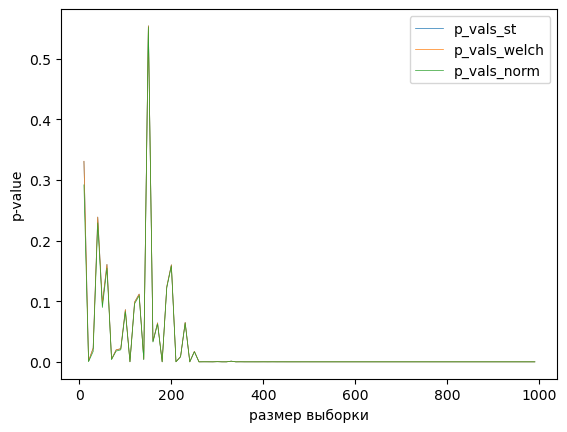

In [8]:
plt.rcParams['lines.linewidth'] = 0.5

df.plot()

plt.title('')
plt.xlabel('размер выборки')
plt.ylabel('p-value')

plt.show();

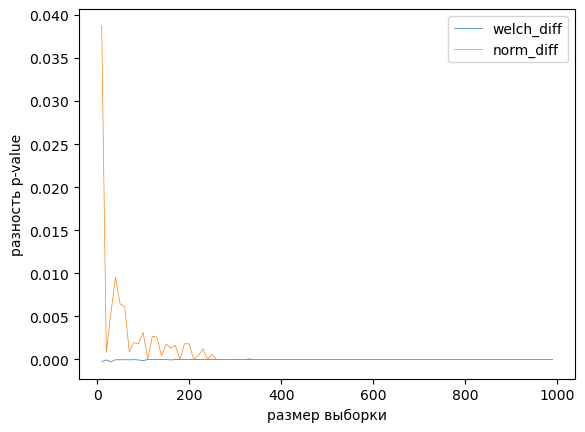

In [9]:
# Чтобы заметить небольшую разницу, давайте 
# воспользуемся колонкой 'p_vals_st' как 
# базовой и вычтем из неё значения из 
# колонок 'p_vals_welch' и 'p_vals_norm'

df['welch_diff'] = df['p_vals_st'] - df['p_vals_welch']
df['norm_diff'] = df['p_vals_st'] - df['p_vals_norm']

df[['welch_diff', 'norm_diff']].plot()

plt.title('')
plt.xlabel('размер выборки')
plt.ylabel('разность p-value')

plt.show();

Приблизительно при выборках объемом 300 все три теста начинают показывать одинаковые значения p-value на примере Пуассоновского распределения. Однако, для других распределений необходимо проводить отдельную проверку.

### Третье требование указывает на неправильность применения t-теста в случае наличия выбросов в выборке. Эффект этого требования можно наглядно продемонстрировать при симуляции А/А и А/Б тестов для расчета значений $\alpha$ и $1-\beta$, которые и являются целью данного ноутбука.

In [10]:
# для начала напишем функцию для расчета размера
# выборки для t-теста

def ttest_sample_size(alpha=0.05, power=0.8, mde=0.1, std1=1,
                      std2=1, equal_var=True) -> tuple:
    """
    Расчет необходимого объема выборки для двухвыборочного t-теста.
    
    Параметры:
        alpha (float): Уровень значимости (вероятность ошибки 1-го рода).
        power (float): Желаемая мощность теста (1 - вероятность ошибки 2-го рода).
        mde (float): Минимально обнаружимый эффект (разница между средними).
        std1 (float): Стандартное отклонение первой выборки.
        std2 (float): Стандартное отклонение второй выборки.
        equal_var (bool): Предполагается ли равенство дисперсий между выборками.
    
    Возвращает:
        tuple(int, int): Кортеж с вычисленными объемами выборки (округленные значения).
    """
    if equal_var:
        effect_size = mde / std1
        div = 2 * (std1 / mde)**2
    else:
        effect_size = mde / (np.sqrt((std1**2 + std2**2) / 2))
        div = (std1**2 + std2**2) / mde**2
    
    z_alpha = stats.norm().ppf(alpha/2)
    z_beta = stats.norm().ppf(1-power)
    theoretical_ss = (z_alpha + z_beta)**2 * div
    
    ttest_power = TTestIndPower()
    sample_size = ttest_power.solve_power(effect_size=effect_size,
                                         nobs1=None,
                                         alpha=alpha,
                                         power=power,
                                         ratio=1,
                                         alternative='two-sided')
    
    return int(np.ceil(theoretical_ss)), int(np.ceil(sample_size))

In [184]:
# параметры аб-теста

alpha = 0.05
power = 0.8

mu1 = 1
mde = 0.025

# для распределения Пуассона дисперсия = мат ожидание
std1 = mu1
std2 = mu1 + mde

# размер одной выборки при заданых 
# параметрах аб-теста
theoretical_ss, sample_size = ttest_sample_size(alpha=alpha, power=power,
                                               mde=mde, std1=std1, std2=std2)

print(f'Sample size = {theoretical_ss, sample_size}')

Sample size = (25117, 25118)


In [190]:
# генерация данных для АБ-теста

data = generate_data(mu1=mu1,
                     mde=mde, 
                     sample_size=theoretical_ss, 
                     func=t_test)

data = np.array(data)
ab_df = pd.DataFrame({
    't_stat': data[:, 0],
    'p_value': data[:, 1]
})

ab_df.head()

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 268.70it/s]


,t_stat,p_value
0,-2.257186,0.023996
1,-3.977921,0.000070
2,-3.142585,0.001675
3,-4.846466,0.000001
4,-0.966218,0.333935


In [191]:
# генерация данных для АA-теста

data = generate_data(mu1=mu1,
                     mde=0, 
                     sample_size=theoretical_ss, 
                     func=t_test)

data = np.array(data)
aa_df = pd.DataFrame({
    't_stat': data[:, 0],
    'p_value': data[:, 1]
})

aa_df.head()

100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 244.90it/s]


,t_stat,p_value
0,-0.751529,0.452334
1,1.013030,0.311046
2,0.472069,0.636877
3,-1.964214,0.049505
4,0.285430,0.775314


In [192]:
def p_value_hist(data, test='AA', alpha=0.05, power=0.8):
    """
    """
    hist = data['p_value'].hist(bins=50)

    ymax = max(hist.get_ybound())
    plt.vlines(x=alpha, ymin=0, ymax=ymax, color='red')
    plt.text(x=alpha+0.02, y=ymax/10, s='alpha = 0.05', rotation=90)

    plt.title(f'{test}-тест, распределение p-value')
    plt.xlabel('p-value')
    plt.ylabel('частота')

    plt.show()

    print(f'Нормированое количество (p-value < {alpha}) = {(data["p_value"] < alpha).sum() / data.shape[0]}')

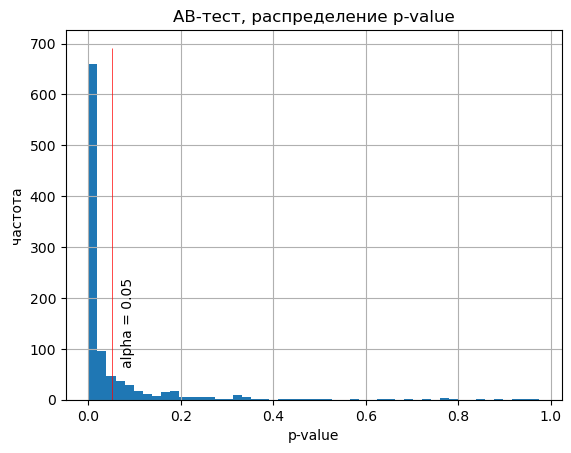

Нормированое количество (p-value < 0.05) = 0.783


In [193]:
p_value_hist(ab_df, test='AB')

При увеличении числа симуляций, данное значение стремится к заданной мощности.

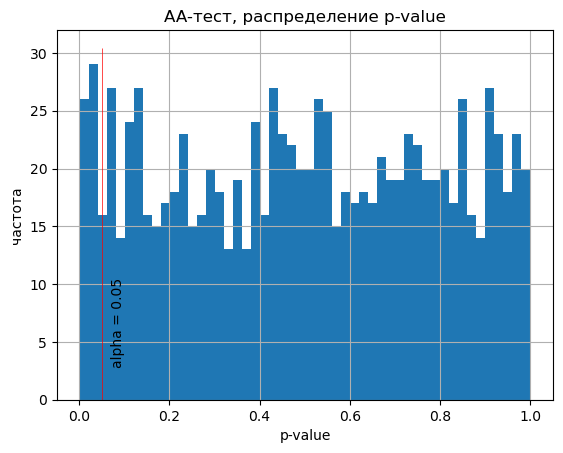

Нормированое количество (p-value < 0.05) = 0.066


In [194]:
p_value_hist(aa_df, test='AA')

При увеличении числа симуляций, данное значение стремится к заданному уровню значимости.

In [150]:
# добавим в данные выбросов из нормального распределения, 
# для этого перепишем функцию generate_data

def generate_data_with_noice(mu1, mde, sample_size, func, range_size=1000):
    result = []
    for _ in tqdm(range(range_size)):
        a = np.random.poisson(lam=mu1, size=sample_size)
        b = np.random.poisson(lam=mu1+mde, size=sample_size)
        
        noice_ss = int(sample_size * 0.01)
        normal_noice = np.random.normal(loc=mu1*3, scale=mu1*3, size=noice_ss)
        
        a = np.concatenate((a, normal_noice))
        b = np.concatenate((b, normal_noice))
        
        result.append(func(a, b))
    
    return result

In [195]:
# генерация данных для АБ-теста

data = generate_data_with_noice(mu1=mu1,
                                 mde=mde, 
                                 sample_size=theoretical_ss, 
                                 func=t_test)

data = np.array(data)
ab_df = pd.DataFrame({
    't_stat': data[:, 0],
    'p_value': data[:, 1]
})

ab_df.head()

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 269.76it/s]


,t_stat,p_value
0,-1.285127,0.198748
1,-2.493012,0.012666
2,-3.195862,0.001394
3,-3.467532,0.000525
4,-2.487547,0.012863


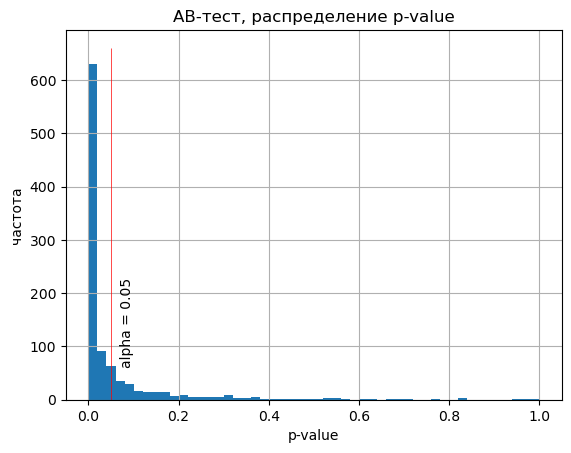

Нормированое количество (p-value < 0.05) = 0.753


In [196]:
p_value_hist(ab_df, test='AB')

In [197]:
# генерация данных для АA-теста

data = generate_data_with_noice(mu1=mu1,
                                 mde=0, 
                                 sample_size=theoretical_ss, 
                                 func=t_test)

data = np.array(data)
aa_df = pd.DataFrame({
    't_stat': data[:, 0],
    'p_value': data[:, 1]
})

aa_df.head()

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 271.53it/s]


,t_stat,p_value
0,-1.101936,0.270489
1,0.104005,0.917165
2,-1.926183,0.054081
3,-0.751145,0.452566
4,-2.034612,0.041890


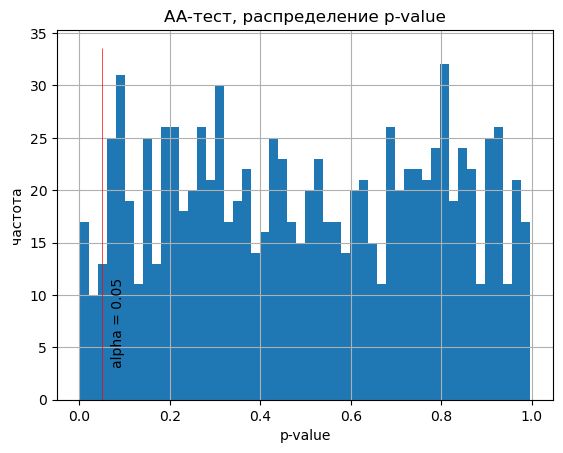

Нормированое количество (p-value < 0.05) = 0.033


In [198]:
p_value_hist(aa_df, test='AA')

В примере выше, я добавил 1% шума в форме нормального распределения, и параметры теста (α, 1-β) начали давать результаты, меньшие, чем ожидалось. Это происходит из-за влияния шума на расчет t-статистики, а именно на посчет дисперсии, которая играет роль нормировки в формуле t-теста.

Больше шума -> Больше дисперсия -> Больше знаменатель -> Меньше t-статистика -> t-статистика реже попадает в хвосты -> ($\alpha$, $1-\beta$) меньше

### U-критерий Манна-Уитни